In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime
import os
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import eigs
from pysindy import SINDy, PolynomialLibrary, STLSQ


In [2]:
name_data = "sample_trajectories_3D.pkl"

In [3]:
os.makedirs("data", exist_ok=True)

Fn = os.path.join(os.getcwd(), "data", name_data)

# Geração aleatória de números
rng = np.random.default_rng()

# Parâmetros de simulação
dt = 1e-6  # Passo de tempo para simulação
dt_out = 1e-4  # Passo de tempo para trajetórias salvas
stride_out = int(np.round(dt_out / dt))
N_sim = 20  # Número de trajetórias a serem geradas

# Número de passos de tempo para cada trajetória
N_steps_mean = int(np.round(0.05 / dt))
N_steps_min = N_steps_mean * 0.5
N_steps_max = N_steps_mean * 1.5
N_steps = rng.integers(low=9999999, high=10000000, size=N_sim)

# Limites das condições iniciais
x_L, y_L = -1.5, -1.5
x_R, y_R = 1.5, 1.5
z_L, z_R = -1.5, 1.5

D = 1.0  # Constante de difusividade
U0 = 2.0
kBT = 1.0  # Energia térmica
alpha = 15.0    # α no artigo
beta = 15.0     # β no artigo
gamma = 0.1     # Termo de amortecimento (2ν no artigo)

def potential(x, y, z):
    return -alpha/2 * (x**2 + y**2 + z**2) + beta/4 * (x**4 + y**4 + z**4)

def a(x, y, z):
    return np.array([
        alpha*x - beta*x**3 - gamma*x,
        alpha*y - beta*y**3 - gamma*y,
        alpha*z - beta*z**3 - gamma*z
    ])

def build_fp_adjoint_1d(grid, D):
    n = len(grid)
    dx = grid[1] - grid[0]
    
    # Operador de difusão (D ∇²)
    D2 = diags([1, -2, 1], [-1, 0, 1], shape=(n, n)) / dx**2
    diffusion = D * D2
    
    # Operador de drift (∇ · [a(x) p])
    x = grid
    a_x = alpha*x - beta*x**3 - gamma*x  # Função de drift
    D1 = diags([-1, 1], [0, 1], shape=(n, n)) / dx  # Derivada primeira (upwind)
    drift = diags(a_x) @ D1
    
    return diffusion + drift

def build_fp_adjoint_3d(x_grid, y_grid, z_grid, D):
    Lx = build_fp_adjoint_1d(x_grid, D)
    Ly = build_fp_adjoint_1d(y_grid, D)
    Lz = build_fp_adjoint_1d(z_grid, D)
    
    # Combina operadores 1D em 3D
    Ix = eye(len(x_grid))
    Iy = eye(len(y_grid))
    Iz = eye(len(z_grid))
    return (kron(kron(Lx, Iy), Iz) + 
            kron(kron(Ix, Ly), Iz) + 
            kron(kron(Ix, Iy), Lz))

trajectories = []
print("{time}\tStarting simulation of {total} trajectories...".format(
    total=N_sim,
    time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
for i in range(N_sim):
    print("{time}\tRunning simulation {cur_int} of {total}...".format(
        cur_int=i + 1,
        total=N_sim,
        time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
        end='\r'
    )
    
    # Gerar array com trajetória atual (3D)
    current_trajectory = np.zeros((N_steps[i] + 1, 3), dtype=float)
    # Condição inicial para a trajetória atual
    current_trajectory[0, 0] = rng.random() * (x_R - x_L) + x_L
    current_trajectory[0, 1] = rng.random() * (y_R - y_L) + y_L
    current_trajectory[0, 2] = rng.random() * (z_R - z_L) + z_L
    
    # Gerar todos os números aleatórios para a simulação atual
    random_numbers_for_current_simulation = rng.normal(size=(N_steps[i], 3))
    random_numbers_for_current_simulation *= np.sqrt(2 * D * dt)
    
    # Algoritmo Euler-Maruyama
    for j in range(N_steps[i]):
        drift = a(current_trajectory[j, 0], current_trajectory[j, 1], current_trajectory[j, 2])
        current_trajectory[j + 1] = current_trajectory[j] + dt * drift + random_numbers_for_current_simulation[j]
    
    # Anexando a trajetória atual à lista de trajetórias
    trajectories.append(current_trajectory[::stride_out])

print("{time}\tFinished simulation of {total} trajectories.              ".format(
    total=N_sim,
    time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
    end='\n'
)

data_to_save = {
    'trajectories': trajectories,
    'parameters': {
        'alpha': alpha,  # Adicione isso!
        'beta': beta,    # Adicione isso!
        'gamma': gamma,
        'D': D,
        'kBT': kBT,
        'x_lim': (x_L, x_R),
        'y_lim': (y_L, y_R),
        'z_lim': (z_L, z_R)
    }
}
pickle.dump(data_to_save, open(Fn, 'wb')) 

2025-06-04 14:53:02	Starting simulation of 20 trajectories...
2025-06-04 15:19:02	Finished simulation of 20 trajectories.              


In [4]:
import numpy as np
import pickle

class inference:

    def build_fokker_planck_adjoint(self, D, alpha, beta, gamma):
        """Constrói o operador adjunto de Fokker-Planck 3D para o modelo do artigo."""
        from scipy.sparse import diags, kron, eye
    
        def one_dim_operator(grid, D_val):
            n = len(grid)
            dx = grid[1] - grid[0]
        
            # Operador de difusão (D ∇²)
            D2 = diags([1, -2, 1], [-1, 0, 1], shape=(n, n)) / dx**2
            diffusion = D_val * D2
        
            # Operador de drift (baseado no artigo: αx - βx³ - γx)
            x = grid
            drift_coeff = alpha*x - beta*x**3 - gamma*x
            D1 = diags([1, -1], [-1, 0], shape=(n, n)) / dx  # Derivada primeira (upwind)
            drift = diags(drift_coeff) @ D1
        
            return diffusion + drift
    
        # Operadores 1D para cada dimensão
        Lx = one_dim_operator(self.x, D)
        Ly = one_dim_operator(self.y, D)
        Lz = one_dim_operator(self.z, D)
    
        # Produto de Kronecker para 3D
        Ix = eye(len(self.x))
        Iy = eye(len(self.y))
        Iz = eye(len(self.z))
    
        return (kron(kron(Lx, Iy), Iz) + 
                kron(kron(Ix, Ly), Iz) + 
                kron(kron(Ix, Iy), Lz))

    def solve_fokker_planck_stationary(self, D, alpha, beta, gamma):
        """Resolve a equação estacionária de Fokker-Planck adjunta."""
        L_adj = self.build_fokker_planck_adjoint(D, alpha, beta, gamma)
    
        from scipy.sparse.linalg import eigs
        # Encontra o autovetor associado ao autovalor mais próximo de zero
        vals, vecs = eigs(L_adj, k=1, sigma=0, which='LM')
        p_stationary = np.abs(vecs[:, 0].real)
    
        # Normaliza a distribuição
        p_stationary /= np.sum(p_stationary)
    
        return p_stationary.reshape(len(self.x), len(self.y), len(self.z))
    def __init__(self, parameters={}):              
        self.index_directory = parameters.get('index_directory', './')
        self.trajectories_filename = parameters.get('trajectories_filename', 'not set')
        self.tau_default = 1  # Define o valor padrão de tau
        
        self.trajectories_loaded = False
        self.index_loaded = False
        self.verbose = parameters.get('verbose', True)
        
        # Definição dos limites para as 3 dimensões
        self.xl = parameters.get('xl', -np.inf)
        self.xr = parameters.get('xr', np.inf)
        self.yl = parameters.get('yl', -np.inf)
        self.yr = parameters.get('yr', np.inf)
        self.zl = parameters.get('zl', -np.inf)
        self.zr = parameters.get('zr', np.inf)

        self.N_bins = parameters.get('N_bins', 100)
        self.dt = parameters.get('dt', 'not set')
        self.dt_out = parameters.get('dt_out', None)

        self.dx = self.dy = self.dz = None
        self.x = self.y = self.z = None
        
        self.set_parameters(parameters)

    def set_parameters(self, parameters={}):
        self.verbose = parameters.get('verbose', self.verbose)
        self.trajectories_filename = parameters.get('trajectories_filename', self.trajectories_filename)
        self.index_directory = parameters.get('index_directory', self.index_directory)

        self.xl = parameters.get('xl', self.xl)
        self.xr = parameters.get('xr', self.xr)
        self.yl = parameters.get('yl', self.yl)
        self.yr = parameters.get('yr', self.yr)
        self.zl = parameters.get('zl', self.zl)
        self.zr = parameters.get('zr', self.zr)

        self.N_bins = parameters.get('N_bins', self.N_bins)
        self.dt = parameters.get('dt', self.dt)
        self.dt_out = parameters.get('dt_out', self.dt_out)
        
        # Definir espaçamento dos bins para cada dimensão
        if self.xl > -np.inf and self.xr < np.inf and self.N_bins > 0:
            self.dx = (self.xr - self.xl) / self.N_bins
            self.dy = (self.yr - self.yl) / self.N_bins
            self.dz = (self.zr - self.zl) / self.N_bins
            
            self.x = self.xl + (np.arange(self.N_bins) + 0.5) * self.dx
            self.y = self.yl + (np.arange(self.N_bins) + 0.5) * self.dy
            self.z = self.zl + (np.arange(self.N_bins) + 0.5) * self.dz
        else:
            self.dx = self.dy = self.dz = None
            self.x = self.y = self.z = None
            
        if self.verbose:
            print("Parâmetros atualizados.")
            
    def get_parameters(self, print_parameters=False):
        """
        Retorna os parâmetros atuais da instância da classe.
        """
        self.index_parameters = {
            'trajectories_filename': self.trajectories_filename,
            'index_directory': self.index_directory,
            'xl': self.xl, 'xr': self.xr, 'dx': self.dx,
            'yl': self.yl, 'yr': self.yr, 'dy': self.dy,
            'zl': self.zl, 'zr': self.zr, 'dz': self.dz,
            'dt': self.dt, 'N_bins': self.N_bins,
            'x': self.x, 'y': self.y, 'z': self.z
        }
    
        if print_parameters:
            print("Parâmetros definidos para esta instância:")
            print(f"trajectories_filename = {self.trajectories_filename}")
            print(f"index_directory       = {self.index_directory}")
            print(f"xl, xr                = {self.xl}, {self.xr}")
            print(f"yl, yr                = {self.yl}, {self.yr}")
            print(f"zl, zr                = {self.zl}, {self.zr}")
            print(f"N_bins                = {self.N_bins}")
            print(f"dt                    = {self.dt}")

        return self.index_parameters
    
    def save_parameters(self):
        """
        Salva os parâmetros atuais em um arquivo pickle.
        """
        with open(self.index_directory + "/index_parameters.pkl", "wb") as f:
            pickle.dump(self.get_parameters(print_parameters=False), f)

        if self.verbose:
            print("Parâmetros salvos com sucesso.")
            
    def load_parameters(self):
        """
        Carrega os parâmetros salvos anteriormente.
        """
        try:
            with open(self.index_directory + "/index_parameters.pkl", "rb") as f:
                index_parameters = pickle.load(f)
        
            self.set_parameters(index_parameters)

            if self.verbose:
                print("Parâmetros carregados com sucesso.")
        except FileNotFoundError:
            raise RuntimeError("Nenhum arquivo de parâmetros encontrado. Certifique-se de que o índice foi salvo corretamente.")


    def load_trajectories(self):
        if self.trajectories_filename == 'not set':
            raise RuntimeError("No filename for trajectories to load provided.")

        self.trajectories = pickle.load(open(f"./data/{self.trajectories_filename}", "rb"))
        
        self.trajectory_lengths = []
        self.yl, self.yr = np.inf, -np.inf
        self.zl, self.zr = np.inf, -np.inf
        self.xl, self.xr = np.inf, -np.inf
        
        for current_trajectory in self.trajectories:
            self.trajectory_lengths.append(len(current_trajectory))
            self.yl = min(self.yl, np.min(current_trajectory[:, 1]))
            self.yr = max(self.yr, np.max(current_trajectory[:, 1]))
            self.zl = min(self.zl, np.min(current_trajectory[:, 2]))
            self.zr = max(self.zr, np.max(current_trajectory[:, 2]))
            self.xl = min(self.xl, np.min(current_trajectory[:, 0]))
            self.xr = max(self.xr, np.max(current_trajectory[:, 0]))
            
        if self.verbose:
            print("Loaded {0} trajectories.".format(len(self.trajectories)))

        self.trajectories_loaded = True
        self.check_bounds_of_spatial_domain()
        
        
    def import_trajectories(self, trajectories):
        """
        Importa trajetórias já carregadas, sem precisar ler do ficheiro.
        """
        self.trajectories = trajectories

        # Inicializa os limites das dimensões
        self.xl, self.xr = np.inf, -np.inf
        self.yl, self.yr = np.inf, -np.inf
        self.zl, self.zr = np.inf, -np.inf

        # Atualiza os limites das posições com base nas trajetórias carregadas
        for traj in self.trajectories:
            self.xl = min(self.xl, np.min(traj[:, 0]))
            self.xr = max(self.xr, np.max(traj[:, 0]))
            self.yl = min(self.yl, np.min(traj[:, 1]))
            self.yr = max(self.yr, np.max(traj[:, 1]))
            self.zl = min(self.zl, np.min(traj[:, 2]))
            self.zr = max(self.zr, np.max(traj[:, 2]))

        if self.verbose:
            print(f"Importadas {len(self.trajectories)} trajetórias.")

        self.trajectories_loaded = True
        self.check_bounds_of_spatial_domain()


        
        
    def create_index(self):
        """
        Cria um índice das trajetórias para facilitar a inferência.
        """
        if not self.trajectories_loaded:
            raise RuntimeError("Por favor, carregue as trajetórias primeiro.")

        self.traj_number = []
        self.traj_index = []
        self.traj_bin_index = []

        for i, current_trajectory in enumerate(self.trajectories):
            for j, position in enumerate(current_trajectory):
                bin_idx_x = int((position[0] - self.xl) // self.dx)
                bin_idx_y = int((position[1] - self.yl) // self.dy)
                bin_idx_z = int((position[2] - self.zl) // self.dz)

                if (0 <= bin_idx_x < self.N_bins) and (0 <= bin_idx_y < self.N_bins) and (0 <= bin_idx_z < self.N_bins):
                    self.traj_number.append(i)
                    self.traj_index.append(j)
                    self.traj_bin_index.append((bin_idx_x, bin_idx_y, bin_idx_z))

        # Converter para arrays NumPy para otimizar o armazenamento e o processamento
        self.traj_number = np.array(self.traj_number, dtype=int)
        self.traj_index = np.array(self.traj_index, dtype=int)
        self.traj_bin_index = np.array(self.traj_bin_index, dtype=int)

        # Criar uma estrutura de índices para cada bin tridimensional
        self.traj_bin_indices = np.vstack([self.traj_number, self.traj_index, self.traj_bin_index.T]).T

        self.index_loaded = True
        if self.verbose:
            print("Índice criado com sucesso.")
            
    def save_index(self):
        """
        Salva o índice gerado para evitar recalcular no futuro.
        """
        if not self.index_loaded:
            raise RuntimeError("Nenhum índice carregado, então nada pode ser salvo.")

        self.save_parameters()

        with open(self.index_directory + "/index_traj_number.pkl", "wb") as f:
            pickle.dump(self.traj_number, f)
    
        with open(self.index_directory + "/index.pkl", "wb") as f:
            pickle.dump(self.traj_index, f)

        with open(self.index_directory + "/index_bin_indices.pkl", "wb") as f:
            pickle.dump(self.traj_bin_indices, f)

        if self.verbose:
            print("Índice salvo com sucesso.")

    def load_index(self):
        """
        Carrega o índice salvo anteriormente.
        """
        self.load_parameters()

        with open(self.index_directory + "/index_traj_number.pkl", "rb") as f:
            self.traj_number = pickle.load(f)

        with open(self.index_directory + "/index.pkl", "rb") as f:
            self.traj_index = pickle.load(f)

        with open(self.index_directory + "/index_bin_indices.pkl", "rb") as f:
            self.traj_bin_indices = pickle.load(f)

        self.index_loaded = True

        if self.verbose:
            print("Índice carregado com sucesso.")



    def check_bounds_of_spatial_domain(self):
        if self.xl < np.min([t[:, 0].min() for t in self.trajectories]):
            self.xl = np.min([t[:, 0].min() for t in self.trajectories])
        if self.xr > np.max([t[:, 0].max() for t in self.trajectories]):
            self.xr = np.max([t[:, 0].max() for t in self.trajectories])
            
        if self.yl < np.min([t[:, 1].min() for t in self.trajectories]):
            self.yl = np.min([t[:, 1].min() for t in self.trajectories])
        if self.yr > np.max([t[:, 1].max() for t in self.trajectories]):
            self.yr = np.max([t[:, 1].max() for t in self.trajectories])
            
        if self.zl < np.min([t[:, 2].min() for t in self.trajectories]):
            self.zl = np.min([t[:, 2].min() for t in self.trajectories])
        if self.zr > np.max([t[:, 2].max() for t in self.trajectories]):
            self.zr = np.max([t[:, 2].max() for t in self.trajectories])
        
        self.set_parameters()

    def get_histogram(self, N_hist=100):
        hist_x, x_edges = np.histogram(
            np.concatenate([trajectory[:, 0] for trajectory in self.trajectories]),
            bins=N_hist, range=(self.xl, self.xr)
        )
        hist_y, y_edges = np.histogram(
            np.concatenate([trajectory[:, 1] for trajectory in self.trajectories]),
            bins=N_hist, range=(self.yl, self.yr) 
        )
        hist_z, z_edges = np.histogram(
            np.concatenate([trajectory[:, 2] for trajectory in self.trajectories]),
            bins=N_hist, range=(self.zl, self.zr)
        )
        return hist_x, x_edges, hist_y, y_edges, hist_z, z_edges

    

    def run_inference(self, tau=1, threshold=0.1):
        """
        Executa a inferência usando regressão esparsa com um atraso temporal tau.

        Parâmetros:
            tau (int): número de passos de tempo entre as amostras usadas na derivada.
            threshold (float): limiar de esparsidade para STLSQ.

        Retorna:
            dict: resultados contendo posições médias, drift estimado e difusão estimada.
        """
        from pysindy import SINDy
        from pysindy.optimizers import STLSQ
        from pysindy.feature_library import PolynomialLibrary
        import numpy as np

         # Concatenar todas as trajetórias
        X_all = []
        X_dot_all = []
        for traj in self.trajectories:
            if len(traj) > tau:
                X_all.append(traj[:-tau])
                X_dot_all.append((traj[tau:] - traj[:-tau]) / (tau * self.dt_out))

        X = np.vstack(X_all)
        X_dot = np.vstack(X_dot_all)

        # Criar e ajustar o modelo SINDy
        library = PolynomialLibrary(degree=5, include_interaction=True)
        self.model = SINDy(
            optimizer=STLSQ(threshold=threshold),
            feature_library=library,
            feature_names=['x', 'y', 'z']
        )
        self.model.fit(X, x_dot=X_dot)

        # Estimar o drift
        drift_pred = self.model.predict(X)


        # Organizar resultados por bins ao longo de x
        N_bins = self.N_bins  # <— usa o atributo que você já definiu
        bins = np.linspace(self.xl, self.xr, N_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        a = np.zeros((N_bins, 3))
        D = np.zeros((N_bins, 3))

        x_vals = X[:, 0]
        for i in range(N_bins):
            mask = (x_vals >= bins[i]) & (x_vals < bins[i+1])
            if np.any(mask):
                a[i] = np.mean(drift_pred[mask], axis=0)
                D[i] = 0.5 * np.var(X_dot[mask], axis=0)

        return {'x': bin_centers, 'a': a, 'D': D}
    
    def kramers_moyal_single_bin(self,
                                bin_index,tau):
        
        ix, iy, iz = bin_index
        mask = (self.traj_bin_indices[:, 2] == ix) & (self.traj_bin_indices[:, 3] == iy) & (self.traj_bin_indices[:, 4] == iz)
        list_of_trajectories_starting_in_bin = self.traj_bin_indices[mask]
        N = len(list_of_trajectories_starting_in_bin)
        # configurar variáveis para <x>, <x^2>, que queremos estimar a partir dos dados
        delta_x = np.zeros(3)  # Para armazenar deslocamentos em 3D
        delta_x_squared = np.zeros(3)
        
        for i,cur_index in enumerate(list_of_trajectories_starting_in_bin):
            
            if cur_index >= len(self.traj_index) or cur_index >= len(self.traj_number):
                print(f"Index {cur_index} is out of bounds for `traj_index` or `traj_number`.")
                continue
                
            traj_num = self.traj_number[cur_index]
            if traj_num >= len(self.trajectory_lengths):
                print(f"Trajectory number {traj_num} is out of bounds.")
                continue
                
            if (self.traj_index[cur_index] + tau) >= self.trajectory_lengths[traj_num]:
                N -= 1
                continue
                
                
            cur_diff = self.trajectories[self.traj_number[cur_index]]   \
                               [self.traj_index[cur_index]+tau]   \
                    - self.trajectories[self.traj_number[cur_index]]   \
                                        [self.traj_index[cur_index]]
            #
            delta_x += cur_diff
            delta_x_squared += cur_diff**2
        #
        if N == 0:
            print('Warning: Encountered a bin with N = 0 datapoints. To avoid '\
                + 'this issue, please i) change the interval size [xl,xr], '\
                + 'ii) decrease tau, or iii) use longer '\
                + 'trajectories.')
            return np.nan, np.nan
        #
        D = delta_x_squared /(2*N*self.dt*tau)
        drift = delta_x / (N*self.dt*tau)
        #l
        return D, drift
    def compare_with_langevin(self, D, alpha, beta, gamma):
        """Compara histograma de Langevin com solução estacionária de Fokker-Planck."""
        import matplotlib.pyplot as plt
    
        # Histograma das trajetórias (Langevin)
        hist_x, x_edges, _, _, _, _ = self.get_histogram()
        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    
        # Solução estacionária (Fokker-Planck)
        p_stationary = self.solve_fokker_planck_stationary(D, alpha, beta, gamma)
        p_x = np.sum(p_stationary, axis=(1, 2))  # Marginaliza em y e z
    
        # Plot comparativo
        plt.figure(figsize=(10, 6))
        plt.bar(x_centers, hist_x/hist_x.sum(), width=x_edges[1]-x_edges[0], 
                alpha=0.5, label='Langevin (simulado)')
        plt.plot(self.x, p_x/p_x.sum(), 'r-', lw=2, label='Fokker-Planck (teórico)')
        plt.xlabel('x')
        plt.ylabel('Densidade de probabilidade')
        plt.legend()
        plt.title('Comparação entre Langevin e Fokker-Planck')

In [5]:
filename = f"./data/{name_data}"

# ---- Carregar as trajetórias do arquivo pickle ----
with open(filename, "rb") as file:
    data = pickle.load(file)

In [6]:
# Verifica se é um dicionário com parâmetros + trajetórias
if isinstance(data, dict) and 'trajectories' in data:
    trajectories = data['trajectories']
    physical_params = data.get('parameters', {
        'alpha': 15.0,
        'beta': 15.0,
        'gamma': 0.1,
        'D': 1.0,
        'x_lim': (-1.5, 1.5),
        'y_lim': (-1.5, 1.5),
        'z_lim': (-1.5, 1.5)
    })
else:
    trajectories = data
    physical_params = {
        'alpha': 15.0,
        'beta': 15.0,
        'gamma': 0.1,
        'D': 1.0,
        'x_lim': (-1.5, 1.5),
        'y_lim': (-1.5, 1.5),
        'z_lim': (-1.5, 1.5)
    }

print(f"Número de trajetórias: {len(trajectories)}")
print(f"Dimensão de uma trajetória: {trajectories[0].shape}")
print(f"Primeira posição (x, y, z): {trajectories[0][0]}")


Número de trajetórias: 20
Dimensão de uma trajetória: (100000, 3)
Primeira posição (x, y, z): [ 0.65608296 -0.14686595 -0.52251131]


In [7]:
# ---- Inicialização da classe inference ----
index_directory = './'
parameters = {
    'dt_out': dt_out,   # passo de amostragem real
    'index_directory': index_directory,
    'trajectories_filename': name_data,
    'dt': dt,
    'xl': physical_params['x_lim'][0],
    'xr': physical_params['x_lim'][1],
    'yl': physical_params['y_lim'][0],
    'yr': physical_params['y_lim'][1],
    'zl': physical_params['z_lim'][0],
    'zr': physical_params['z_lim'][1],
    'verbose': True
}

# Criar instância
infer = inference(parameters)
infer.dt_out = dt_out 

Parâmetros atualizados.


In [8]:
# Configurar número de bins
N_bins = 120
infer.set_parameters({'N_bins': N_bins})

# Adicionar os parâmetros físicos à instância
infer.physical_params = physical_params

# Verificar
print("\nParâmetros físicos carregados:")
for key, val in physical_params.items():
    print(f"{key} = {val}")
print()

infer.get_parameters(print_parameters=True)

# Carregar as trajetórias do arquivo
infer.trajectories = trajectories
infer.check_bounds_of_spatial_domain()



Parâmetros atualizados.

Parâmetros físicos carregados:
alpha = 15.0
beta = 15.0
gamma = 0.1
D = 1.0
kBT = 1.0
x_lim = (-1.5, 1.5)
y_lim = (-1.5, 1.5)
z_lim = (-1.5, 1.5)

Parâmetros definidos para esta instância:
trajectories_filename = sample_trajectories_3D.pkl
index_directory       = ./
xl, xr                = -1.5, 1.5
yl, yr                = -1.5, 1.5
zl, zr                = -1.5, 1.5
N_bins                = 120
dt                    = 1e-06
Parâmetros atualizados.


In [9]:
infer.xl, infer.xr = physical_params['x_lim']
infer.yl, infer.yr = physical_params['y_lim']
infer.zl, infer.zr = physical_params['z_lim']

In [10]:
# Mostrar os parâmetros atualizados
infer.get_parameters(print_parameters=True)

Parâmetros definidos para esta instância:
trajectories_filename = sample_trajectories_3D.pkl
index_directory       = ./
xl, xr                = -1.5, 1.5
yl, yr                = -1.5, 1.5
zl, zr                = -1.5, 1.5
N_bins                = 120
dt                    = 1e-06


{'trajectories_filename': 'sample_trajectories_3D.pkl',
 'index_directory': './',
 'xl': -1.5,
 'xr': 1.5,
 'dx': 0.025,
 'yl': -1.5,
 'yr': 1.5,
 'dy': 0.025,
 'zl': -1.5,
 'zr': 1.5,
 'dz': 0.025,
 'dt': 1e-06,
 'N_bins': 120,
 'x': array([-1.4875, -1.4625, -1.4375, -1.4125, -1.3875, -1.3625, -1.3375,
        -1.3125, -1.2875, -1.2625, -1.2375, -1.2125, -1.1875, -1.1625,
        -1.1375, -1.1125, -1.0875, -1.0625, -1.0375, -1.0125, -0.9875,
        -0.9625, -0.9375, -0.9125, -0.8875, -0.8625, -0.8375, -0.8125,
        -0.7875, -0.7625, -0.7375, -0.7125, -0.6875, -0.6625, -0.6375,
        -0.6125, -0.5875, -0.5625, -0.5375, -0.5125, -0.4875, -0.4625,
        -0.4375, -0.4125, -0.3875, -0.3625, -0.3375, -0.3125, -0.2875,
        -0.2625, -0.2375, -0.2125, -0.1875, -0.1625, -0.1375, -0.1125,
        -0.0875, -0.0625, -0.0375, -0.0125,  0.0125,  0.0375,  0.0625,
         0.0875,  0.1125,  0.1375,  0.1625,  0.1875,  0.2125,  0.2375,
         0.2625,  0.2875,  0.3125,  0.3375,  0.3625,  0.

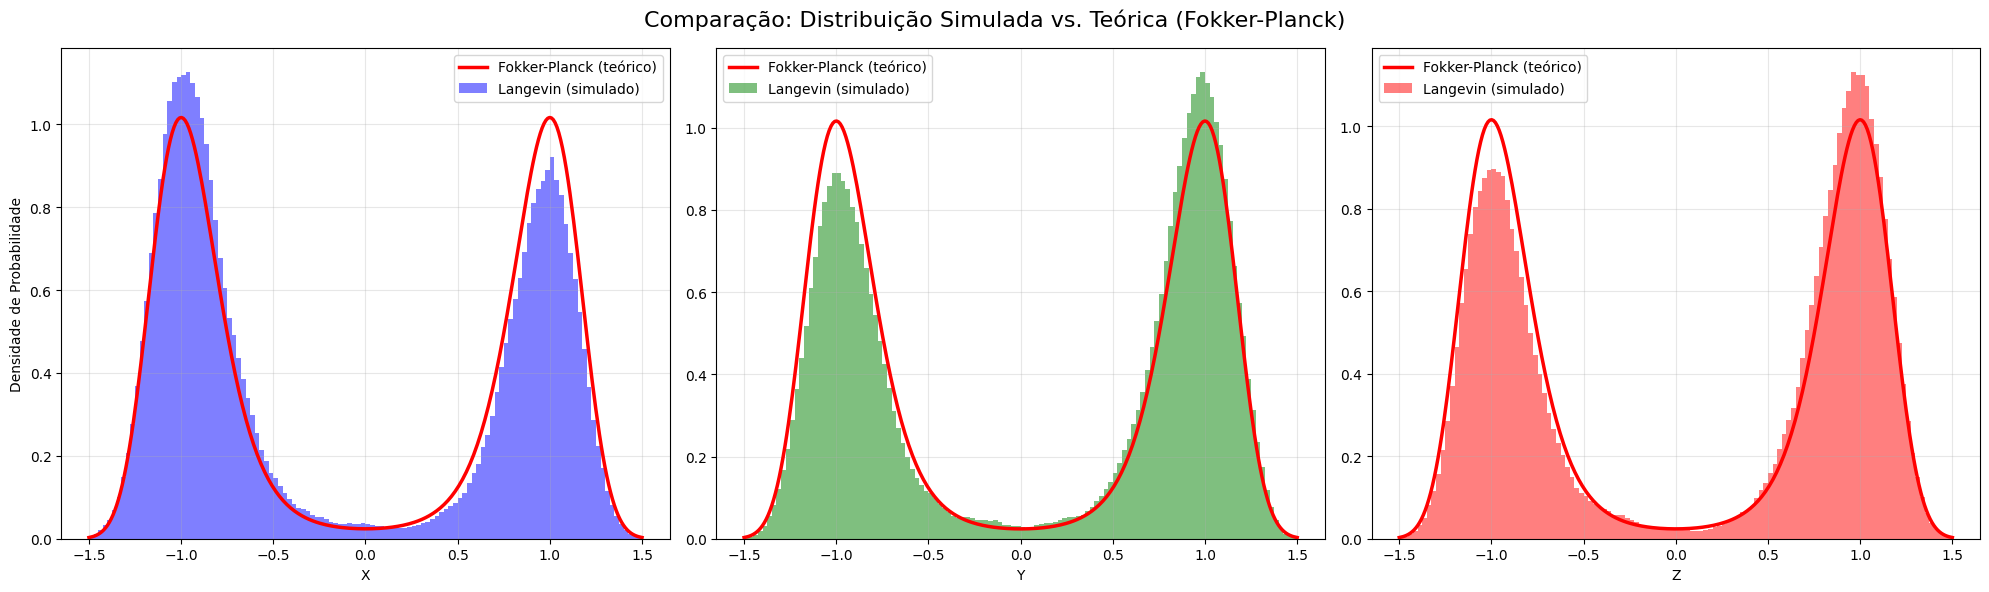

In [11]:
from scipy.integrate import trapezoid
# ---- Configuração dos histogramas ----
hist_x, bin_edges_x, hist_y, bin_edges_y, hist_z, bin_edges_z = infer.get_histogram(N_hist=N_bins)

# Cálculo dos centros e larguras dos bins
def get_bin_properties(edges):
    centers = (edges[1:] + edges[:-1]) / 2
    width = centers[1] - centers[0]
    return centers, width

bin_centers_x, bar_width_x = get_bin_properties(bin_edges_x)
bin_centers_y, bar_width_y = get_bin_properties(bin_edges_y)
bin_centers_z, bar_width_z = get_bin_properties(bin_edges_z)

# ---- Distribuição teórica (Fokker-Planck) ----
def theoretical_distribution(x, alpha, beta, gamma, D):
    """Solução estacionária da equação de Fokker-Planck para o potencial V(x) = -α/2 x² + β/4 x⁴"""
    V = -alpha / 2 * x**2 + beta / 4 * x**4
    p = np.exp(-V / D)
    p /= trapezoid(p, x)  # Normalização robusta
    return p

# Vetores contínuos para avaliar a solução analítica
x_fp = np.linspace(infer.xl, infer.xr, 300)
y_fp = np.linspace(infer.yl, infer.yr, 300)
z_fp = np.linspace(infer.zl, infer.zr, 300)

# Distribuições teóricas
alpha = physical_params['alpha']
beta = physical_params['beta']
gamma = physical_params['gamma']
D = physical_params['D']

p_x = theoretical_distribution(x_fp, alpha, beta, gamma, D)
p_y = theoretical_distribution(y_fp, alpha, beta, gamma, D)
p_z = theoretical_distribution(z_fp, alpha, beta, gamma, D)

# Normalizar histogramas (densidade de probabilidade)
hist_x_norm = hist_x / (hist_x.sum() * bar_width_x)
hist_y_norm = hist_y / (hist_y.sum() * bar_width_y)
hist_z_norm = hist_z / (hist_z.sum() * bar_width_z)

# ---- Visualização: Comparação entre Fokker-Planck e histograma de Langevin ----
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Posição X
ax[0].bar(bin_centers_x, hist_x_norm, width=bar_width_x, color='blue', alpha=0.5, label='Langevin (simulado)')
ax[0].plot(x_fp, p_x, 'r-', lw=2.5, label='Fokker-Planck (teórico)')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Densidade de Probabilidade')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Posição Y
ax[1].bar(bin_centers_y, hist_y_norm, width=bar_width_y, color='green', alpha=0.5, label='Langevin (simulado)')
ax[1].plot(y_fp, p_y, 'r-', lw=2.5, label='Fokker-Planck (teórico)')
ax[1].set_xlabel('Y')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Posição Z
ax[2].bar(bin_centers_z, hist_z_norm, width=bar_width_z, color='red', alpha=0.5, label='Langevin (simulado)')
ax[2].plot(z_fp, p_z, 'r-', lw=2.5, label='Fokker-Planck (teórico)')
ax[2].set_xlabel('Z')
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.suptitle("Comparação: Distribuição Simulada vs. Teórica (Fokker-Planck)", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
# Criação e salvamento do índice de inferência
infer.trajectories_loaded = True
infer.create_index()
infer.save_index()


Índice criado com sucesso.
Parâmetros salvos com sucesso.
Índice salvo com sucesso.


In [13]:
inference

__main__.inference

In [14]:
dt = 1e-6  # Passo temporal 

In [15]:
from pysindy import SINDy
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary
from scipy.signal import savgol_filter
# Configurações do modelo
optimizer = STLSQ(threshold=0.01)
library = PolynomialLibrary(degree=5, include_interaction=True)

# Cálculo de derivadas sem normalização
X_all = []
X_dot_all = []
for traj in trajectories:
    X_all.append(traj[:-1])
    X_dot_all.append((traj[1:] - traj[:-1]) / dt)

X = np.vstack(X_all)
X_dot = np.vstack(X_dot_all)
X_dot = savgol_filter(X_dot, window_length=5, polyorder=2, axis=0)  # Suaviza derivadas

# Treinamento do modelo
model = SINDy(optimizer=optimizer, feature_library=library, feature_names=['x', 'y', 'z'])
model.fit(X, x_dot=X_dot, quiet=False)

# Exibir coeficientes de forma legível
print("\nCoeficientes identificados:")
for i, dim in enumerate(['x', 'y', 'z']):
    coefs = model.coefficients()[i]
    non_zero_coefs = {name: f"{coef:.4f}" for name, coef in zip(model.get_feature_names(), coefs) if abs(coef) > 0.001}
    print(f"Dimensão {dim}:", non_zero_coefs)


Coeficientes identificados:
Dimensão x: {'1': '47.3229', 'x': '854.3191', 'y': '-74.8791', 'z': '130.6444', 'x^2': '135.4434', 'x y': '-18.9357', 'x z': '8.6954', 'y^2': '-108.0030', 'y z': '23.8047', 'z^2': '-177.5854', 'x^3': '-882.2335', 'x^2 y': '98.8922', 'x^2 z': '-15.8373', 'x y^2': '-118.0847', 'x y z': '65.0364', 'x z^2': '-5.1442', 'y^3': '-8.7159', 'y^2 z': '3.2261', 'y z^2': '70.8069', 'z^3': '-217.0298', 'x^4': '-40.4555', 'x^3 y': '10.3123', 'x^3 z': '-23.7428', 'x^2 y^2': '-52.1797', 'x^2 y z': '0.3054', 'x^2 z^2': '-29.0444', 'x y^3': '52.5973', 'x y^2 z': '0.4601', 'x y z^2': '-57.5257', 'x z^3': '28.1204', 'y^4': '59.0218', 'y^3 z': '1.7264', 'y^2 z^2': '78.2031', 'y z^3': '-24.8545', 'z^4': '76.3375', 'x^5': '33.8390', 'x^4 y': '-38.1045', 'x^4 z': '-58.6416', 'x^3 y^2': '88.5442', 'x^3 y z': '-25.2068', 'x^3 z^2': '-5.1483', 'x^2 y^3': '57.9284', 'x^2 y^2 z': '14.6898', 'x^2 y z^2': '-52.2137', 'x^2 z^3': '101.2682', 'x y^4': '20.1499', 'x y^3 z': '-14.7818', 'x y^

In [16]:
# Coeficientes esperados
coefs_esperados = {
    'x': [-15.1, 15.0, -2.6667],
    'y': [-15.1, 15.0, -2.6667],
    'z': [-15.1, 15.0, -2.6667]
}

print("\nComparação com o modelo teórico:")
erros = []
for i, dim in enumerate(['x', 'y', 'z']):
    coefs_dict = {name: coef for name, coef in zip(model.get_feature_names(), model.coefficients()[i])}
    coefs_identificados = np.array([coefs_dict.get(t, 0.0) for t in ['x', 'x^3', 'x^5']])
    print(f"\nDimensão {dim}:")
    print("Identificado:", np.round(coefs_identificados, 2))
    print("Esperado:    ", coefs_esperados[dim])
    if len(coefs_identificados) == 3:
        erro = np.linalg.norm(coefs_identificados - coefs_esperados[dim]) / np.linalg.norm(coefs_esperados[dim])
        erros.append(erro)

if erros:
    print(f"\nErro relativo médio: {np.mean(erros)*100:.1f}%")
else:
    print("\nNão foi possível calcular o erro: número de coeficientes incompatível.")



Comparação com o modelo teórico:

Dimensão x:
Identificado: [ 854.32 -882.23   33.84]
Esperado:     [-15.1, 15.0, -2.6667]

Dimensão y:
Identificado: [-102.11   28.59   12.9 ]
Esperado:     [-15.1, 15.0, -2.6667]

Dimensão z:
Identificado: [-93.39  40.69 -30.54]
Esperado:     [-15.1, 15.0, -2.6667]

Erro relativo médio: 2216.4%



Inferindo com τ = 10


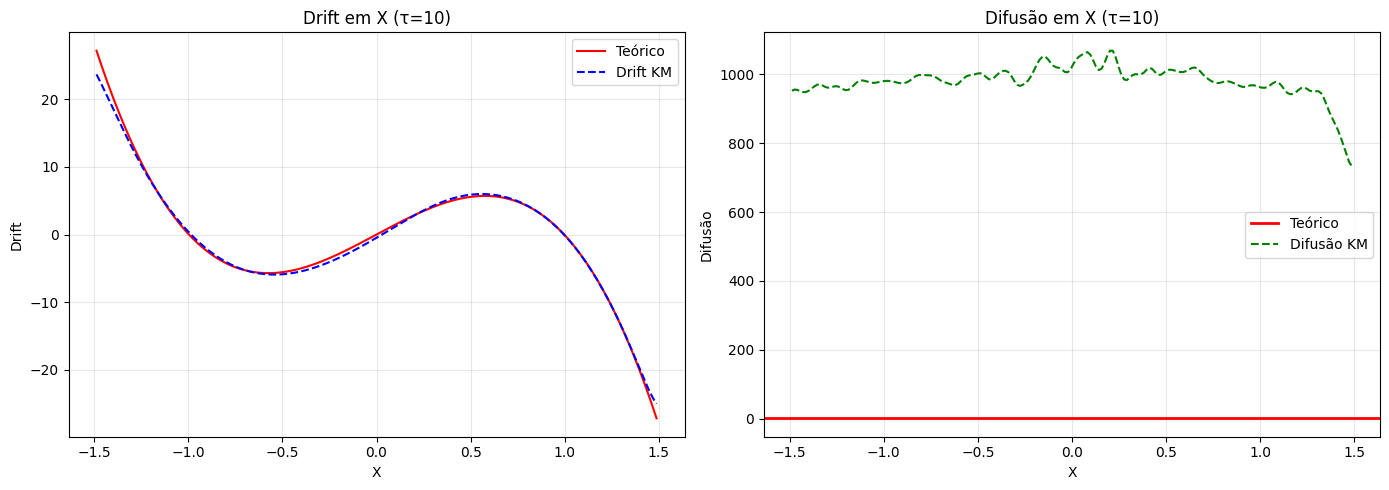


Inferindo com τ = 50


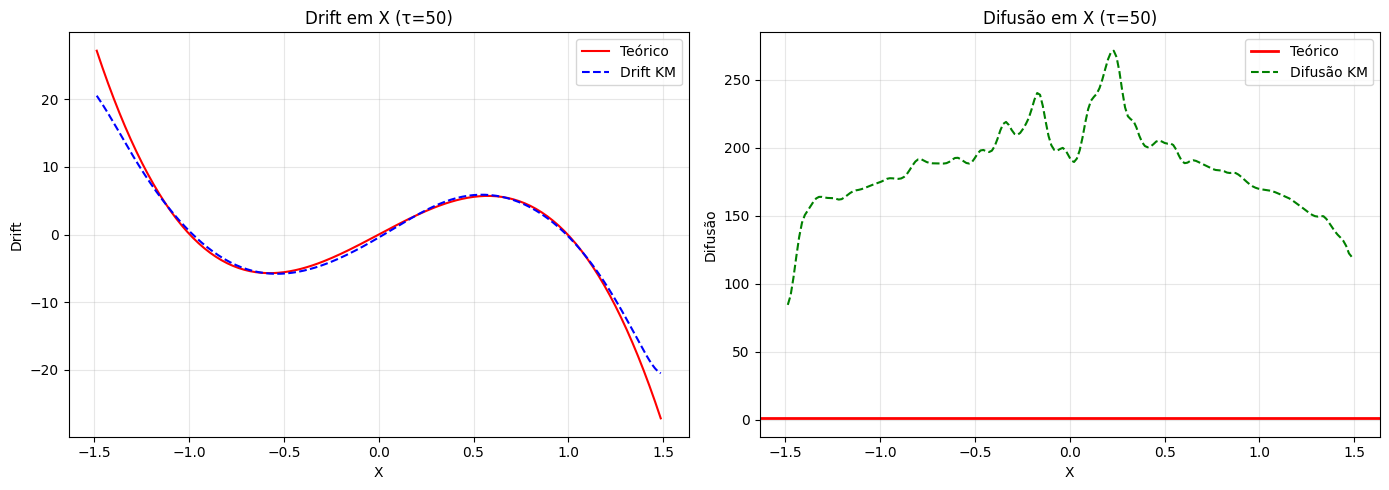


Inferindo com τ = 100


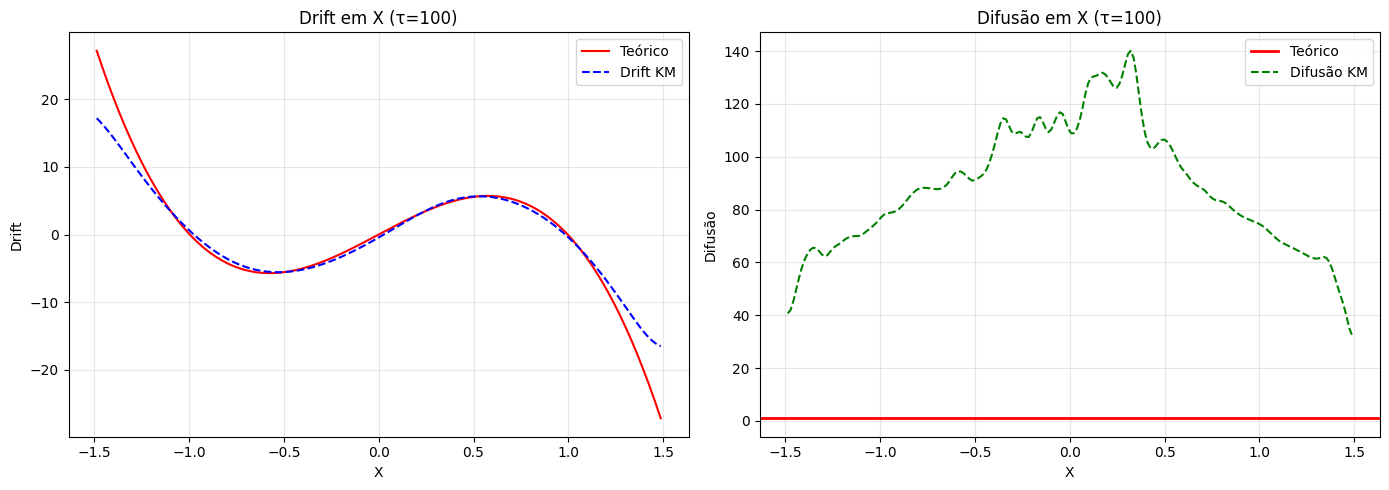


Inferindo com τ = 200


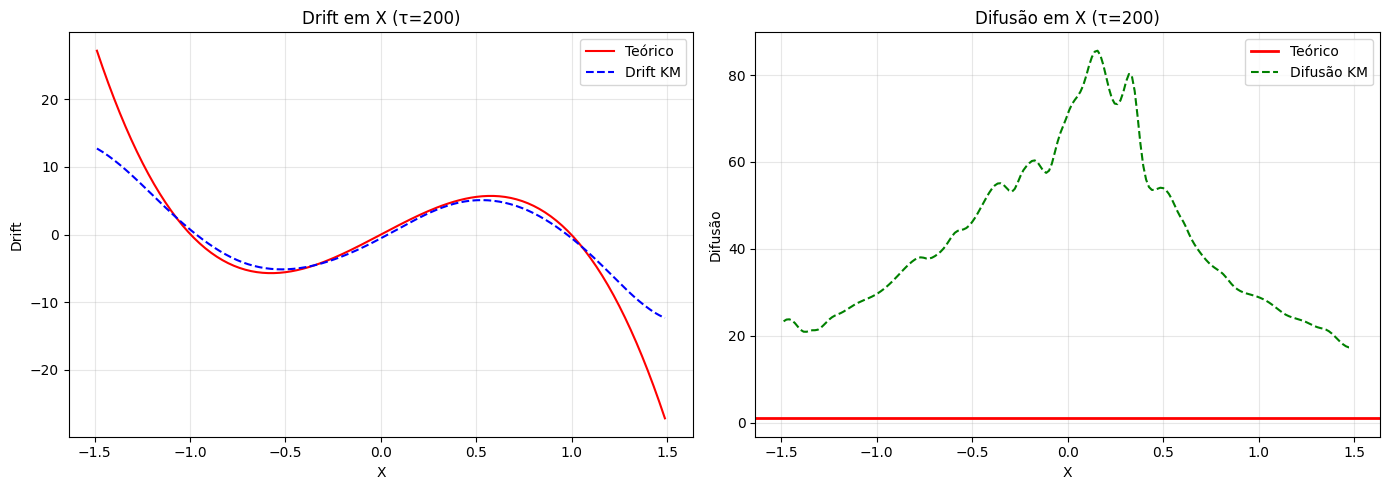

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

tau_values = [10, 50, 100, 200]
alpha, beta, gamma = 15.0, 15.0, 0.1

for τ in tau_values:
    print(f"\nInferindo com τ = {τ}")
    res = infer.run_inference(tau=τ)   # usa apenas tau

    x_vals = res['x']
    a_vals = res['a'][:, 0]
    D_vals = res['D'][:, 0]

    # Suaviza para plot
    a_s = gaussian_filter1d(a_vals, sigma=1)
    D_s = gaussian_filter1d(D_vals, sigma=1)

    spline_a = UnivariateSpline(x_vals, a_s, s=0.5)
    spline_D = UnivariateSpline(x_vals, D_s, s=0.5)
    x_range = np.linspace(x_vals.min(), x_vals.max(), 200)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    # Drift teórico vs inferido
    ax1.plot(x_range, (alpha-gamma)*x_range - beta*x_range**3, 'r-', label='Teórico')
    ax1.plot(x_range, spline_a(x_range),   'b--', label='Drift KM')
    ax1.set(title=f'Drift em X (τ={τ})', xlabel='X', ylabel='Drift')
    ax1.legend(); ax1.grid(alpha=0.3)

    # Difusão teórica vs inferida
    ax2.axhline(1.0, color='r', lw=2, label='Teórico')
    ax2.plot(x_range, spline_D(x_range), 'g--', label='Difusão KM')
    ax2.set(title=f'Difusão em X (τ={τ})', xlabel='X', ylabel='Difusão')
    ax2.legend(); ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Inferindo com τ = 10


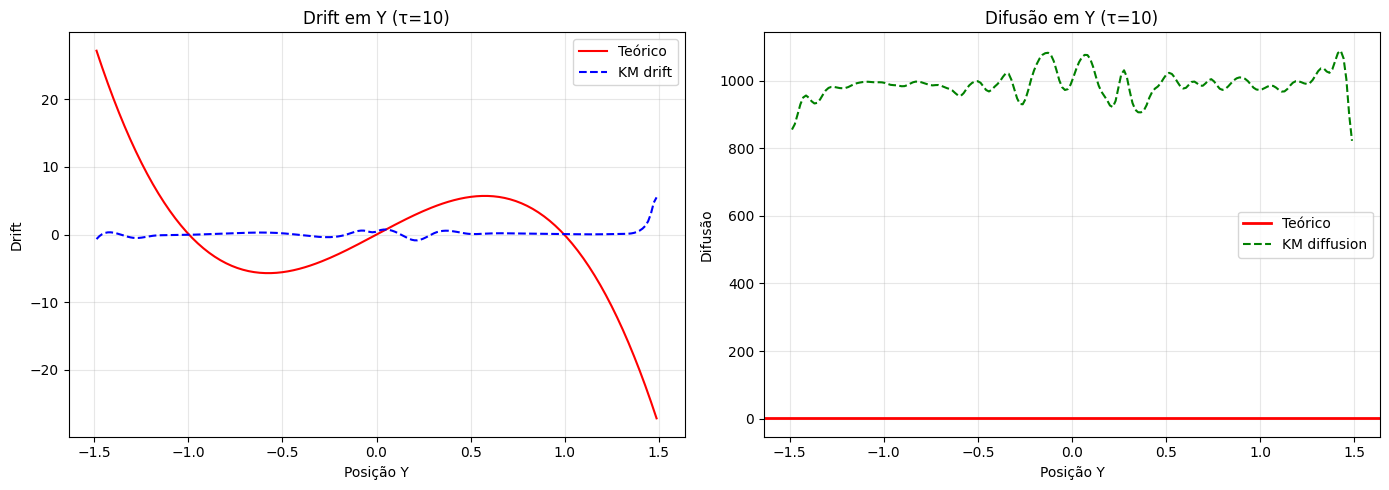


Inferindo com τ = 50


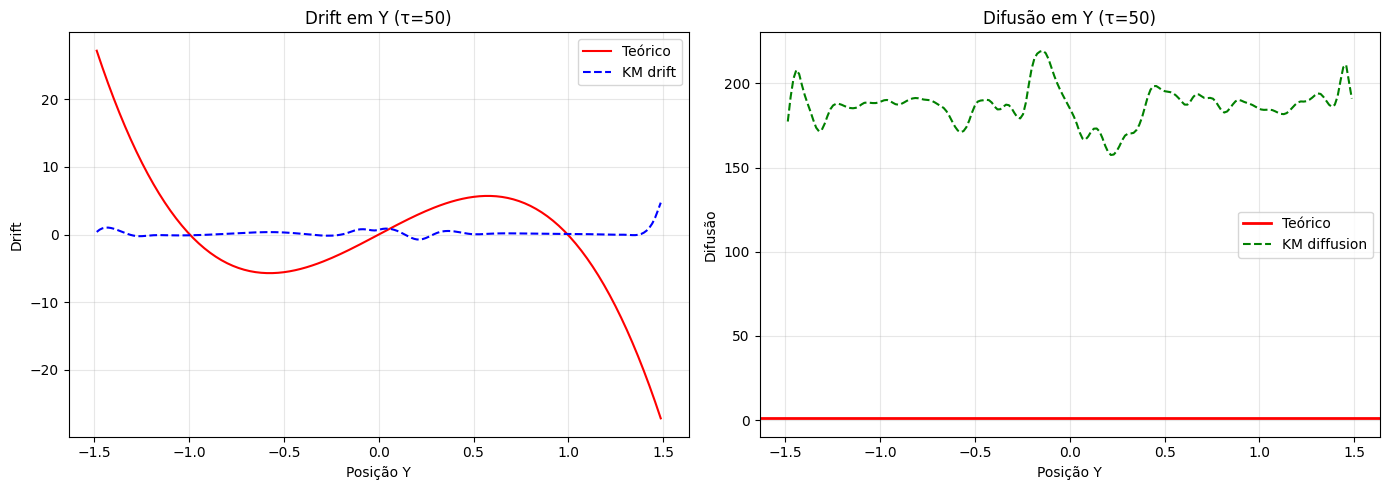


Inferindo com τ = 100


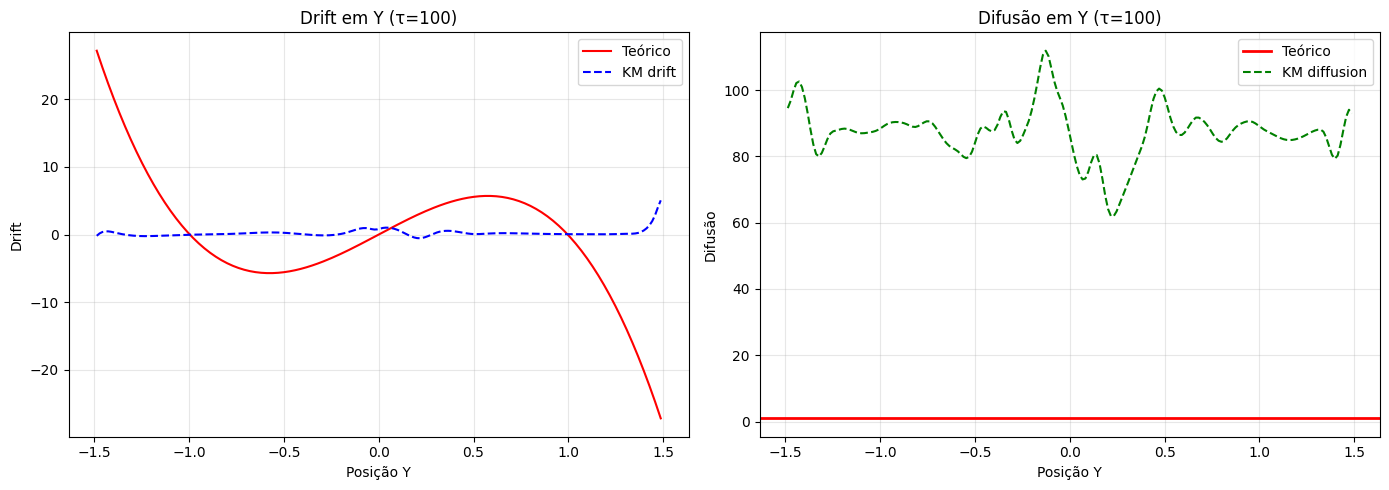


Inferindo com τ = 200


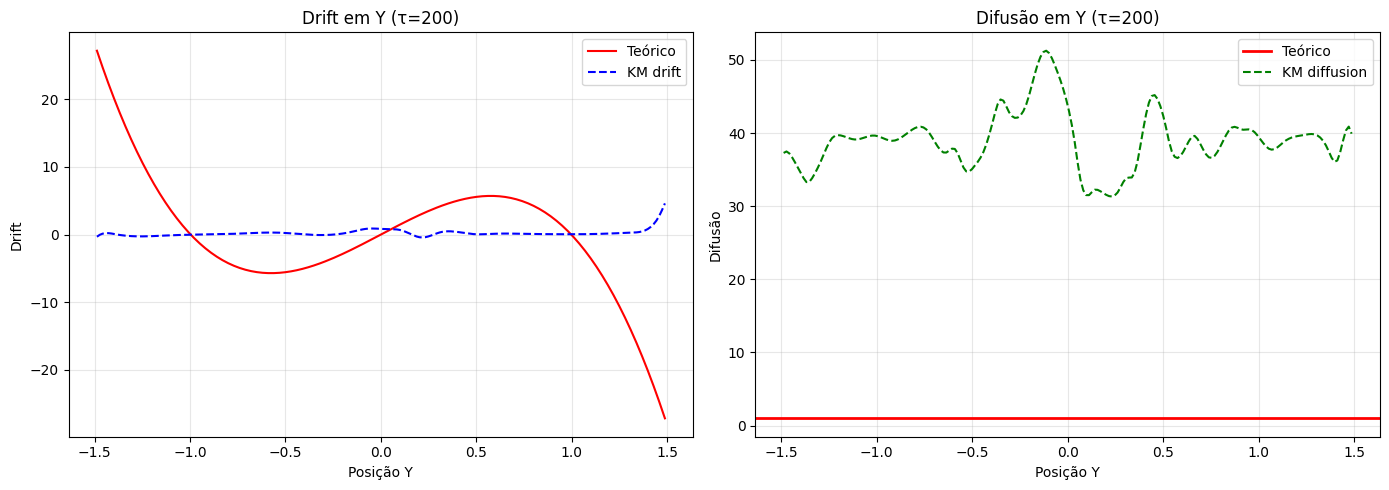

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

tau_values = [10, 50, 100, 200]
alpha, beta, gamma = 15.0, 15.0, 0.1

for τ in tau_values:
    print(f"\nInferindo com τ = {τ}")
    res = infer.run_inference(tau=τ)

    y_vals = res['x']        # centros de bin em y (mesmo eixo usado internamente)
    a_y   = res['a'][:, 1]   # drift estimado em Y
    D_y   = res['D'][:, 1]   # difusão estimada em Y

    # Suavização para plot
    a_s = gaussian_filter1d(a_y, sigma=1)
    D_s = gaussian_filter1d(D_y, sigma=1)

    # Splines para curvas suaves
    spline_a = UnivariateSpline(y_vals, a_s, s=0.5)
    spline_D = UnivariateSpline(y_vals, D_s, s=0.5)
    y_range = np.linspace(y_vals.min(), y_vals.max(), 200)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- Drift teórico vs inferido em Y ---
    A_teorico_y = (alpha - gamma) * y_range - beta * y_range**3
    ax1.plot(y_range, A_teorico_y, 'r-', label='Teórico')
    ax1.plot(y_range, spline_a(y_range), 'b--', label='KM drift')
    ax1.set(title=f'Drift em Y (τ={τ})',
            xlabel='Posição Y',
            ylabel='Drift')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # --- Difusão teórica vs inferida em Y ---
    ax2.axhline(1.0, color='r', lw=2, label='Teórico')
    ax2.plot(y_range, spline_D(y_range), 'g--', label='KM diffusion')
    ax2.set(title=f'Difusão em Y (τ={τ})',
            xlabel='Posição Y',
            ylabel='Difusão')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

Partícula #0: primeiros 5 instantes e posições
t = 0.00000 s → x=0.6561, y=-0.1469, z=-0.5225
t = 0.00010 s → x=0.6294, y=-0.1372, z=-0.5396
t = 0.00020 s → x=0.6254, y=-0.1371, z=-0.5459
t = 0.00030 s → x=0.6576, y=-0.1491, z=-0.5391
t = 0.00040 s → x=0.6457, y=-0.1601, z=-0.5146


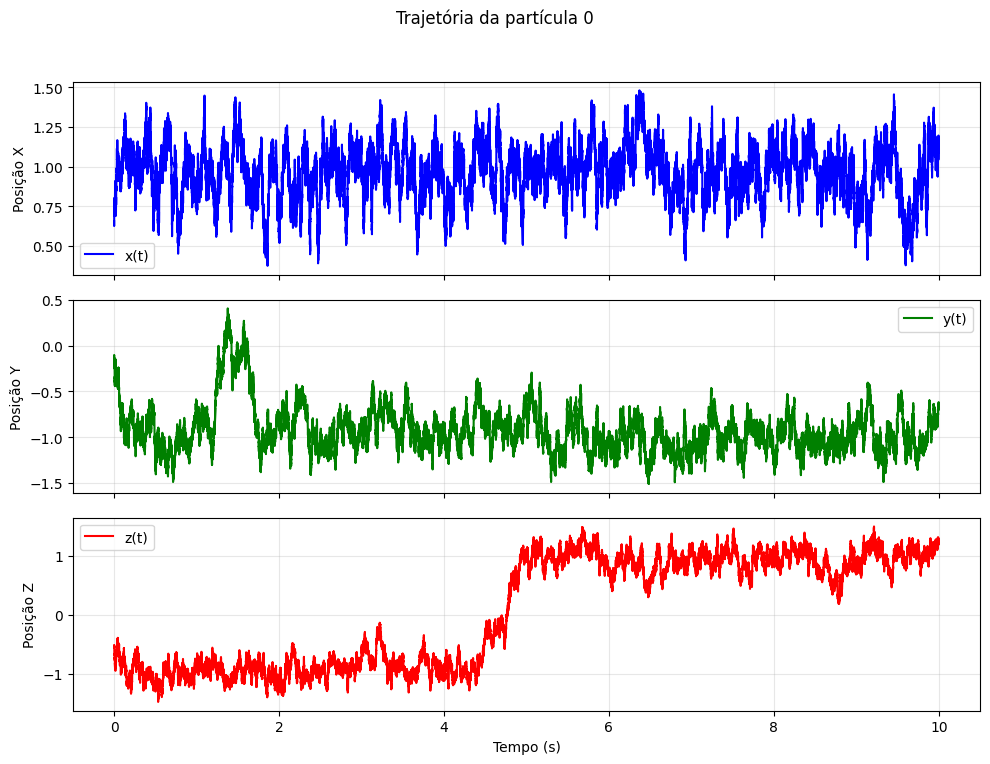

In [19]:
# Célula: Trajetória de uma única partícula (x, y, z vs. tempo)

# Índice da partícula que você quer visualizar
particle_index = 0  # altere para qualquer 0 ≤ particle_index < len(trajectories)

# Extrai a trajetória e monta o vetor de tempos
traj = trajectories[particle_index]       # formato (N_out_steps, 3)
times = np.arange(traj.shape[0]) * dt_out  # t = 0, dt_out, 2·dt_out, …

# Impressão rápida dos primeiros pontos
print(f"Partícula #{particle_index}: primeiros 5 instantes e posições")
for i in range(5):
    print(f"t = {times[i]:.5f} s → x={traj[i,0]:.4f}, y={traj[i,1]:.4f}, z={traj[i,2]:.4f}")

# Plot: x, y e z vs. tempo em subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(times, traj[:, 0], 'b-', label='x(t)')
axs[0].set_ylabel('Posição X')
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(times, traj[:, 1], 'g-', label='y(t)')
axs[1].set_ylabel('Posição Y')
axs[1].legend()
axs[1].grid(alpha=0.3)

axs[2].plot(times, traj[:, 2], 'r-', label='z(t)')
axs[2].set_ylabel('Posição Z')
axs[2].set_xlabel('Tempo (s)')
axs[2].legend()
axs[2].grid(alpha=0.3)

plt.suptitle(f'Trajetória da partícula {particle_index}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

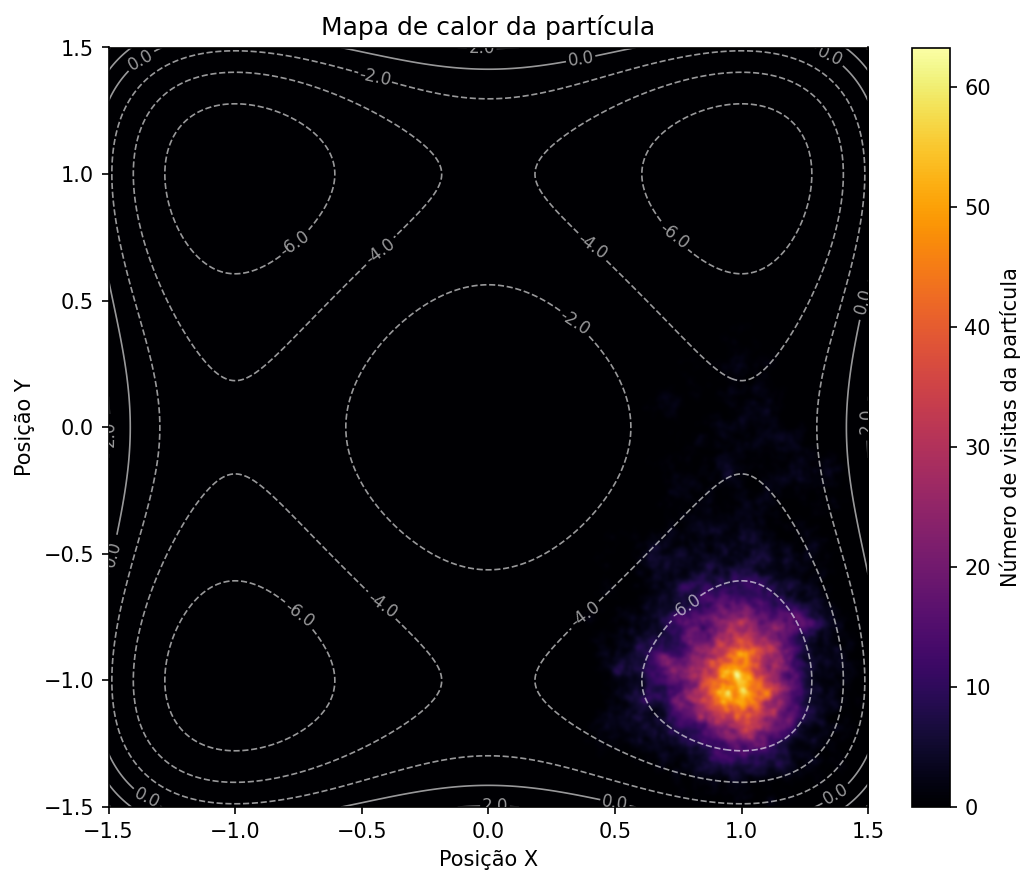

In [20]:
# Célula: Heatmap de ocupação de alta definição

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parâmetros
particle_index = 0    # partícula a plotar
N_bins = 300          # bins em cada direção (mais bins = mais resolução)
sigma_smooth = 0.7    # suavização (quanto menor, mais “nítido”)
cmap = 'inferno'

# Extrai trajetória
traj = trajectories[particle_index]
x, y = traj[:,0], traj[:,1]

# Domínio (dos seus parâmetros infer)
x_min, x_max = infer.xl, infer.xr
y_min, y_max = infer.yl, infer.yr

# 1) histograma 2D
counts, x_edges, y_edges = np.histogram2d(
    x, y,
    bins=N_bins,
    range=[[x_min, x_max], [y_min, y_max]]
)

# 2) suaviza levemente
counts_smooth = gaussian_filter(counts, sigma=sigma_smooth)

# 3) plota com imshow e interpolação bicubic
fig = plt.figure(figsize=(8, 6), dpi=150)    # DPI mais alto para maior definição
ax = fig.add_subplot(111)

# imshow espera matriz [rows,cols], então transponha counts_smooth
im = ax.imshow(
    counts_smooth.T,
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    aspect='equal',
    cmap=cmap,
    interpolation='bicubic'   # interpolação para suavizar pixels
)

# Opcional: adicionar contornos do potencial
alpha, beta = physical_params['alpha'], physical_params['beta']
xx = np.linspace(x_min, x_max, 400)
yy = np.linspace(y_min, y_max, 400)
XX, YY = np.meshgrid(xx, yy)
V = -alpha/2*(XX**2 + YY**2) + beta/4*(XX**4 + YY**4)
cs = ax.contour(XX, YY, V, levels=6, colors='white', linewidths=0.8, alpha=0.6)
ax.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

# Ajustes finais
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Número de visitas da partícula')
ax.set_xlabel('Posição X')
ax.set_ylabel('Posição Y')
ax.set_title(f'Mapa de calor da partícula')
plt.tight_layout()
plt.show()

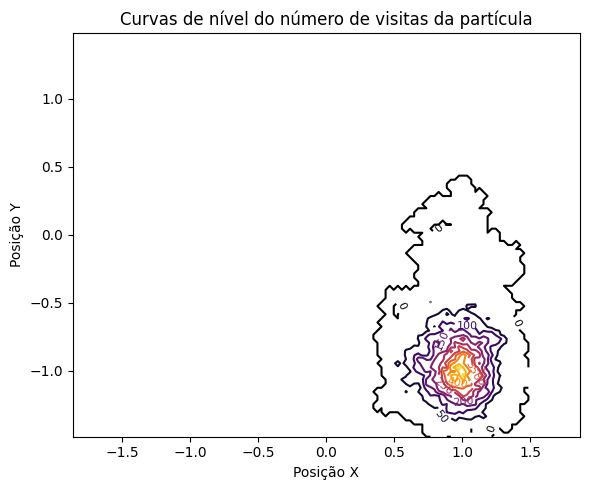

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que x e y sejam as trajetórias da partícula
# Aqui você gera a matriz de visitas (histograma 2D)
H, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[-1.5, 1.5], [-1.5, 1.5]])

X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)

plt.figure(figsize=(6, 5))

# Apenas as curvas de nível da densidade
contours = plt.contour(X, Y, H.T, levels=10, cmap='inferno')  # ou outra paleta se quiser
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')

plt.xlabel('Posição X')
plt.ylabel('Posição Y')
plt.title('Curvas de nível do número de visitas da partícula')
plt.grid(False)
plt.axis('equal')
plt.tight_layout()
plt.show()


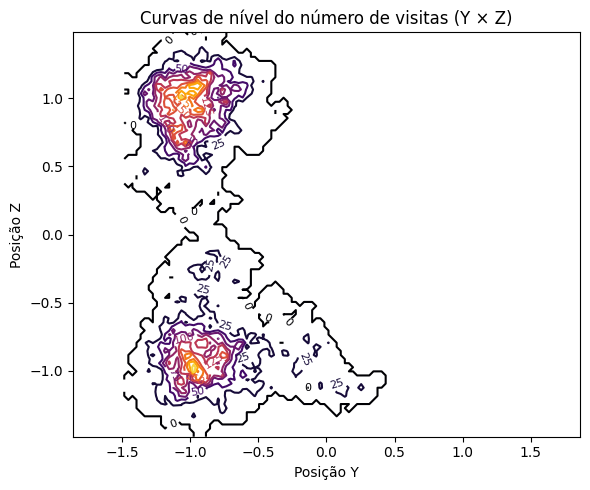

In [22]:
# Exemplo para plano Y-Z
y = traj[:, 1]
z = traj[:, 2]

H, yedges, zedges = np.histogram2d(y, z, bins=100, range=[[-1.5, 1.5], [-1.5, 1.5]])
Y, Z = np.meshgrid((yedges[:-1] + yedges[1:]) / 2, (zedges[:-1] + zedges[1:]) / 2)

plt.figure(figsize=(6, 5))
contours = plt.contour(Y, Z, H.T, levels=10, cmap='inferno')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')
plt.xlabel('Posição Y')
plt.ylabel('Posição Z')
plt.title('Curvas de nível do número de visitas (Y × Z)')
plt.axis('equal')
plt.tight_layout()
plt.show()

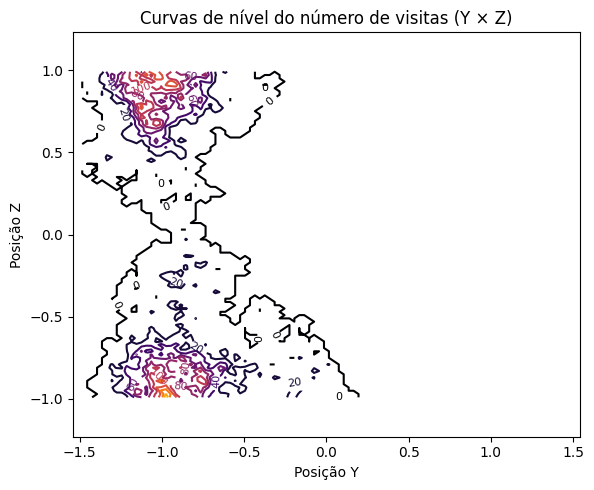

In [23]:
# Exemplo para plano Y-Z
y = traj[:, 1]
z = traj[:, 2]

H, yedges, zedges = np.histogram2d(y, z, bins=100, range=[[-1.5, 1.5], [-1.0, 1.0]])
Y, Z = np.meshgrid((yedges[:-1] + yedges[1:]) / 2, (zedges[:-1] + zedges[1:]) / 2)

plt.figure(figsize=(6, 5))
contours = plt.contour(Y, Z, H.T, levels=10, cmap='inferno')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')
plt.xlabel('Posição Y')
plt.ylabel('Posição Z')
plt.title('Curvas de nível do número de visitas (Y × Z)')
plt.axis('equal')
plt.tight_layout()
plt.show()

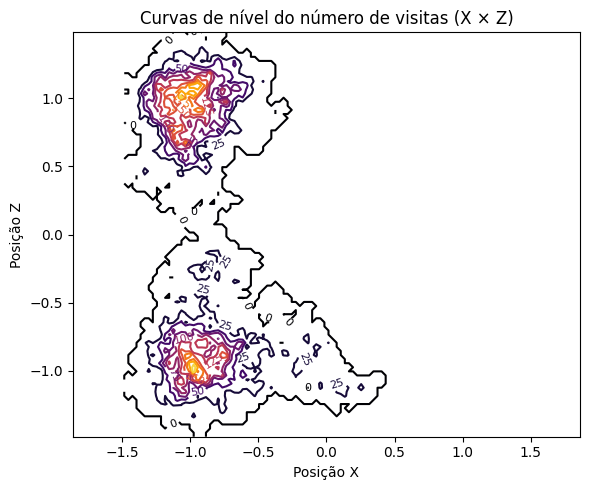

In [24]:
# Exemplo para plano Y-Z
x = traj[:, 1]
z = traj[:, 2]

H, xedges, zedges = np.histogram2d(x, z, bins=100, range=[[-1.5, 1.5], [-1.5, 1.5]])
X, Z = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (zedges[:-1] + zedges[1:]) / 2)

plt.figure(figsize=(6, 5))
contours = plt.contour(X, Z, H.T, levels=10, cmap='inferno')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')
plt.xlabel('Posição X')
plt.ylabel('Posição Z')
plt.title('Curvas de nível do número de visitas (X × Z)')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [25]:
pip install matplotlib networkx numpy

Note: you may need to restart the kernel to use updated packages.


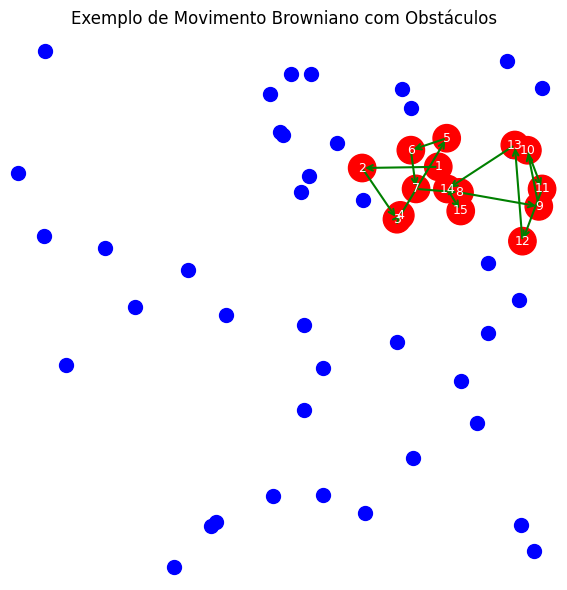

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
n_steps = 15
n_fixed = 40
area_size = 10

# Geração de obstáculos fixos (azuis)
fixed_x = np.random.uniform(0, area_size, size=n_fixed)
fixed_y = np.random.uniform(0, area_size, size=n_fixed)

# Trajetória da partícula (aleatória)
trajectory = np.zeros((n_steps, 2))
trajectory[0] = [np.random.uniform(0, area_size), np.random.uniform(0, area_size)]
for i in range(1, n_steps):
    dx, dy = np.random.normal(0, 1, 2)
    trajectory[i] = trajectory[i-1] + [dx, dy]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Obstáculos fixos (azuis)
ax.scatter(fixed_x, fixed_y, color='blue', s=100)

# Trajetória móvel (vermelhos com numeração)
for i, (x, y) in enumerate(trajectory):
    circle = plt.Circle((x, y), 0.25, color='red', zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, str(i+1), color='white', fontsize=9, ha='center', va='center', zorder=4)

# Setas entre os pontos
for i in range(n_steps - 1):
    x0, y0 = trajectory[i]
    x1, y1 = trajectory[i+1]
    ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", color='green', lw=1.5))

ax.set_xlim(0, area_size)
ax.set_ylim(0, area_size)
ax.set_aspect('equal')
ax.set_title('Exemplo de Movimento Browniano com Obstáculos')
plt.grid(False)
plt.axis('off')
plt.tight_layout()
plt.show()

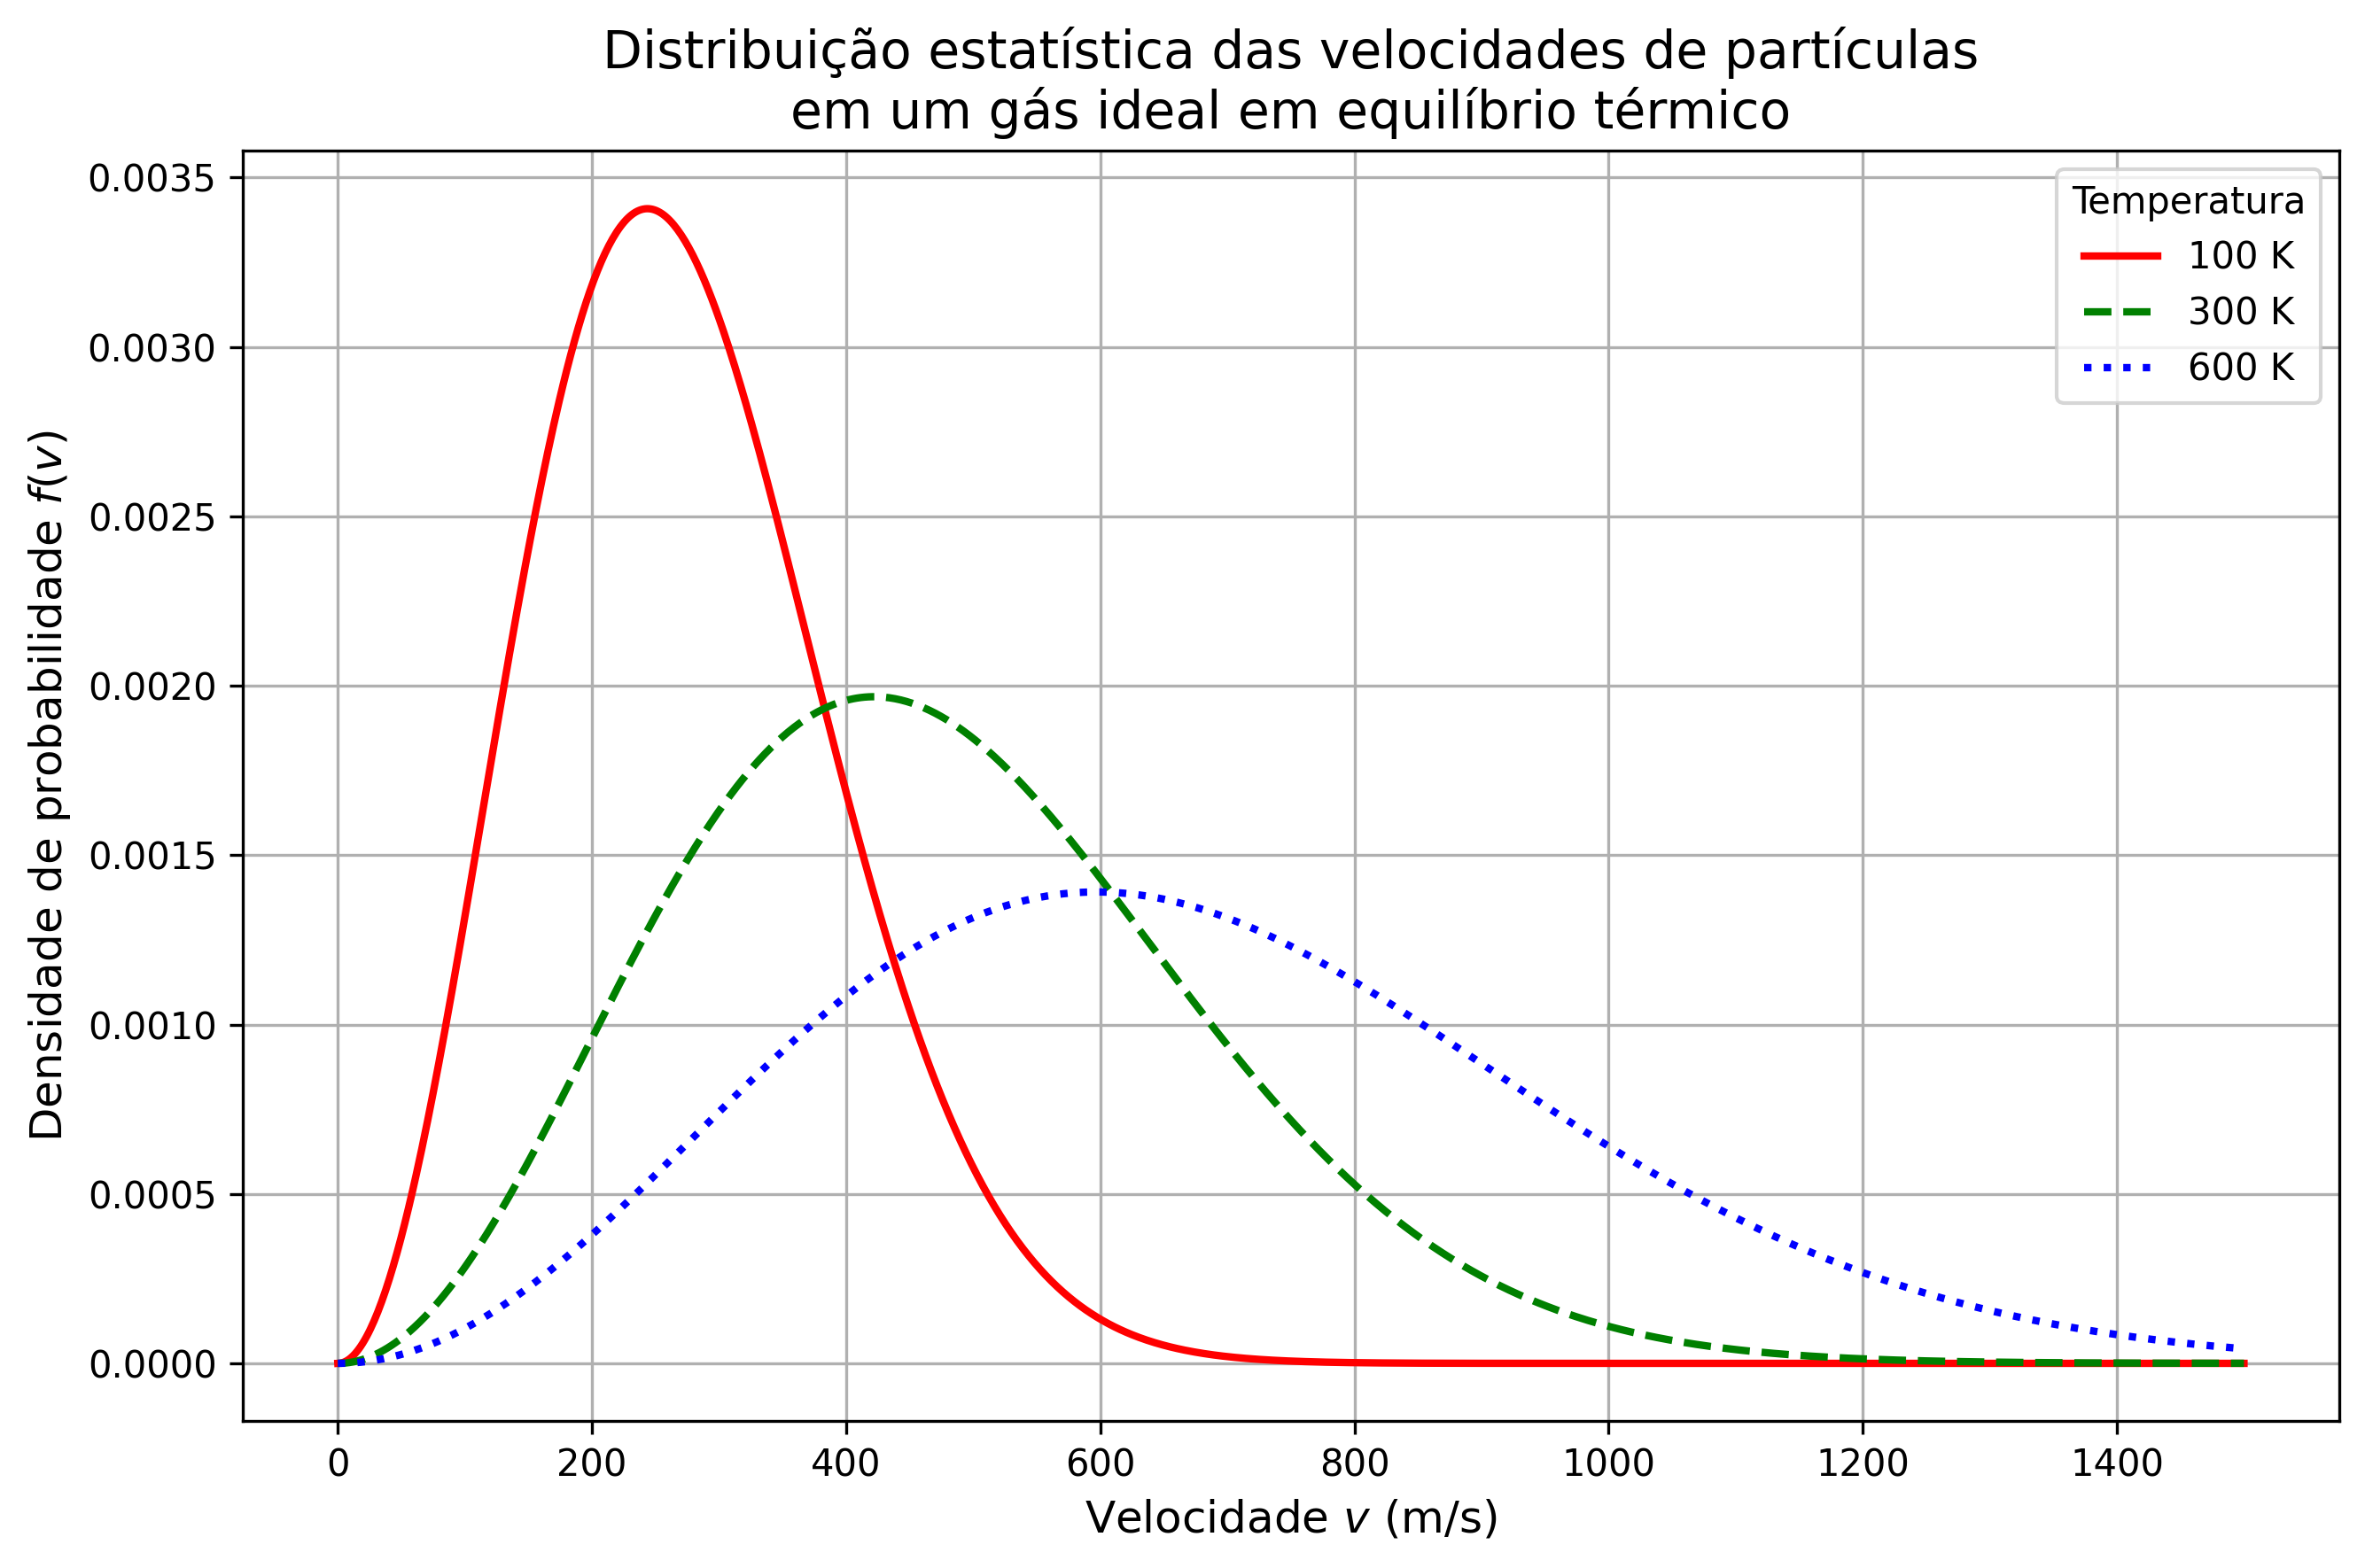

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes físicas
kB = 1.38e-23      # Constante de Boltzmann (J/K)
m = 4.65e-26       # Massa da molécula de ar (kg)

# Temperaturas a simular
temperaturas = [100, 300, 600]  # em Kelvin
cores = ['red', 'green', 'blue']
estilos = ['-', '--', ':']
labels = [f'{T} K' for T in temperaturas]

# Eixo de velocidades
v = np.linspace(0, 1500, 1000)

# Função de distribuição de Maxwell-Boltzmann (densidade de probabilidade)
def maxwell_boltzmann(v, T):
    factor = 4 * np.pi * (m / (2 * np.pi * kB * T))**1.5
    return factor * v**2 * np.exp(-m * v**2 / (2 * kB * T))

# Criar gráfico
plt.figure(figsize=(9, 6), dpi=300)

for T, cor, estilo, label in zip(temperaturas, cores, estilos, labels):
    f_v = maxwell_boltzmann(v, T)
    plt.plot(v, f_v, linestyle=estilo, color=cor, linewidth=2, label=label)

# Estética e rótulos estatísticos
plt.xlabel('Velocidade $v$ (m/s)', fontsize=12)
plt.ylabel('Densidade de probabilidade $f(v)$', fontsize=12)
plt.title('Distribuição estatística das velocidades de partículas\nem um gás ideal em equilíbrio térmico', fontsize=14)
plt.legend(title='Temperatura', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Salvar como imagem de alta definição
plt.savefig('distribuicao_maxwell_boltzmann.png', dpi=300)
plt.show()

Partícula #0: primeiros 5 instantes e posições
t = 0.00000 s → x=0.6561, y=-0.1469, z=-0.5225
t = 0.00010 s → x=0.6294, y=-0.1372, z=-0.5396
t = 0.00020 s → x=0.6254, y=-0.1371, z=-0.5459
t = 0.00030 s → x=0.6576, y=-0.1491, z=-0.5391
t = 0.00040 s → x=0.6457, y=-0.1601, z=-0.5146


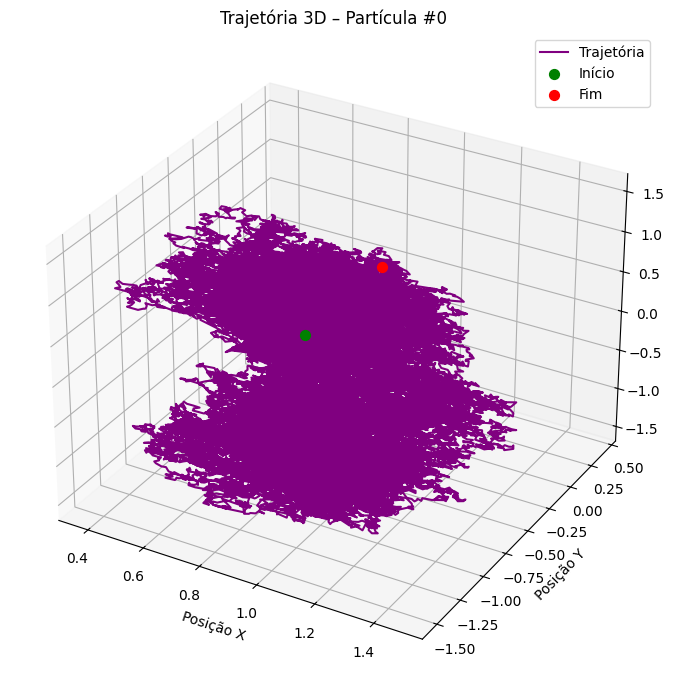

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessário para 3D

# Índice da partícula a ser visualizada
particle_index = 0  # você pode alterar para outra partícula

# Extração da trajetória
traj = trajectories[particle_index]       # shape (N, 3)
times = np.arange(traj.shape[0]) * dt_out

# Impressão dos primeiros pontos
print(f"Partícula #{particle_index}: primeiros 5 instantes e posições")
for i in range(5):
    print(f"t = {times[i]:.5f} s → x={traj[i,0]:.4f}, y={traj[i,1]:.4f}, z={traj[i,2]:.4f}")

# Gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Trajetória completa
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='purple', lw=1.5, label='Trajetória')

# Destaque do ponto inicial e final
ax.scatter(*traj[0], color='green', s=50, label='Início')
ax.scatter(*traj[-1], color='red', s=50, label='Fim')

# Estética do gráfico
ax.set_title(f'Trajetória 3D – Partícula #{particle_index}')
ax.set_xlabel('Posição X')
ax.set_ylabel('Posição Y')
ax.set_zlabel('Z')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

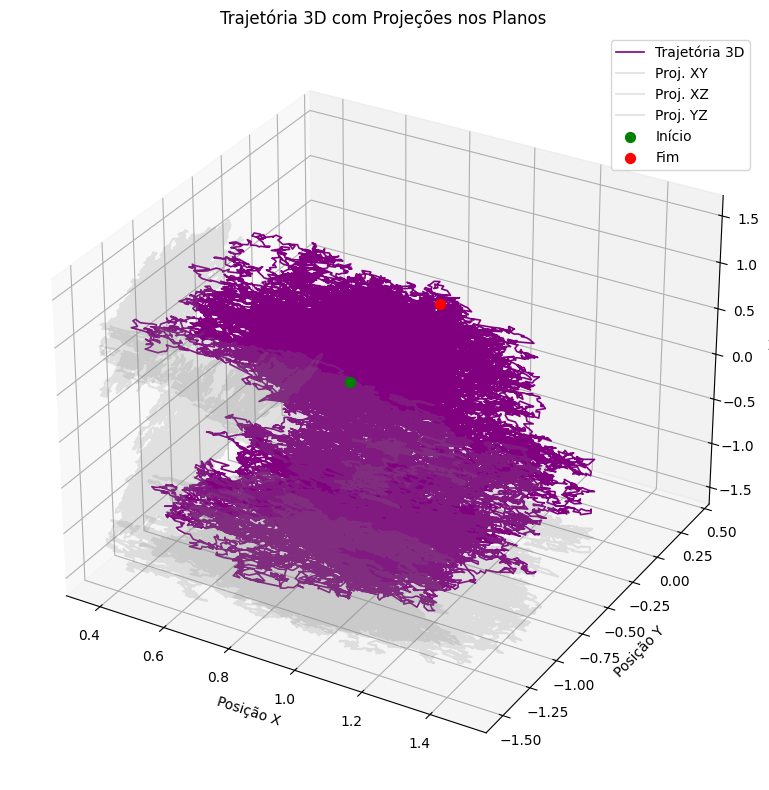

In [29]:
# Trajetória da partícula (assumindo que já foi extraída)
traj = trajectories[0]  # (N, 3)
x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Trajetória principal
ax.plot(x, y, z, color='purple', lw=1.2, label='Trajetória 3D')

# Projeções 2D (como sombras nos planos)
ax.plot(x, y, zs=z.min(), zdir='z', alpha=0.2, color='gray', label='Proj. XY')
ax.plot(x, z, zs=y.min(), zdir='y', alpha=0.2, color='gray', label='Proj. XZ')
ax.plot(y, z, zs=x.min(), zdir='x', alpha=0.2, color='gray', label='Proj. YZ')

# Início e fim
ax.scatter(x[0], y[0], z[0], color='green', s=50, label='Início')
ax.scatter(x[-1], y[-1], z[-1], color='red', s=50, label='Fim')

# Estética
ax.set_xlabel('Posição X')
ax.set_ylabel('Posição Y')
ax.set_zlabel('Z')
ax.set_title('Trajetória 3D com Projeções nos Planos')
ax.legend()
plt.tight_layout()
plt.show()